In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error #gives us more penalty for 
#predictions that are way off, may need to adjust this metric for different data sets
 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Outline: 
- Outlier Analysis
- Forecasting horizon
- Time series cross validation
- Lag features
- Predicting the future

In [2]:
df= pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

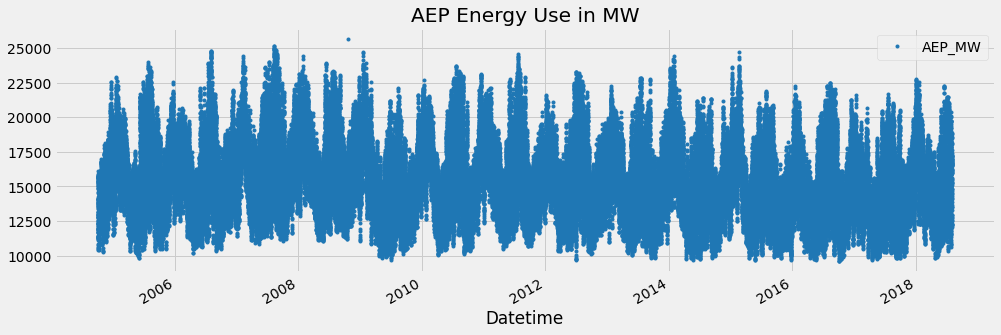

In [3]:
df.plot(style = '.', figsize=(15, 5), color = color_pal[0], title = 'AEP Energy Use in MW')
plt.show()

## Outlier Analysis and Removal

<AxesSubplot:ylabel='Frequency'>

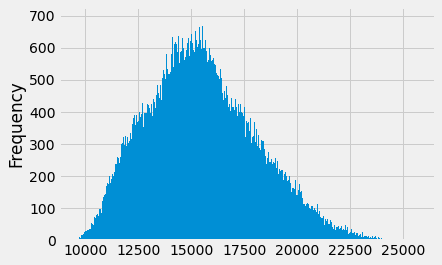

In [4]:
df['AEP_MW'].plot(kind = 'hist', bins = 500)

<AxesSubplot:xlabel='Datetime'>

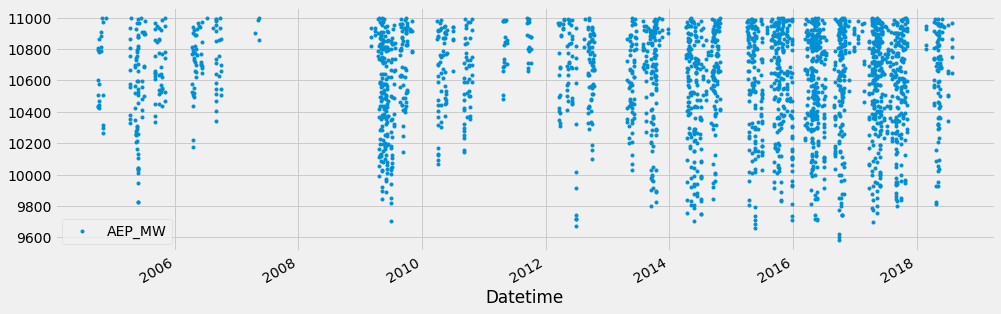

In [5]:
df.query('AEP_MW < 11_000').plot(figsize=(15,5), style = '.')

No outlier need to be removed

## Train / Test Split

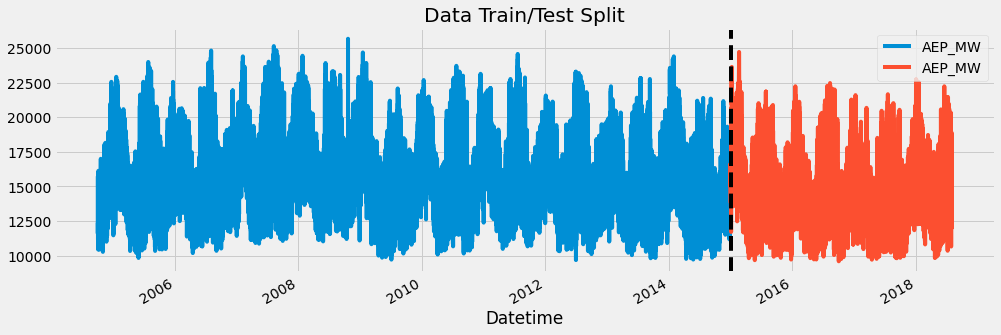

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label= 'Test Set')
ax.axvline('01-01-2015',color = 'black', ls='--' )
plt.show()


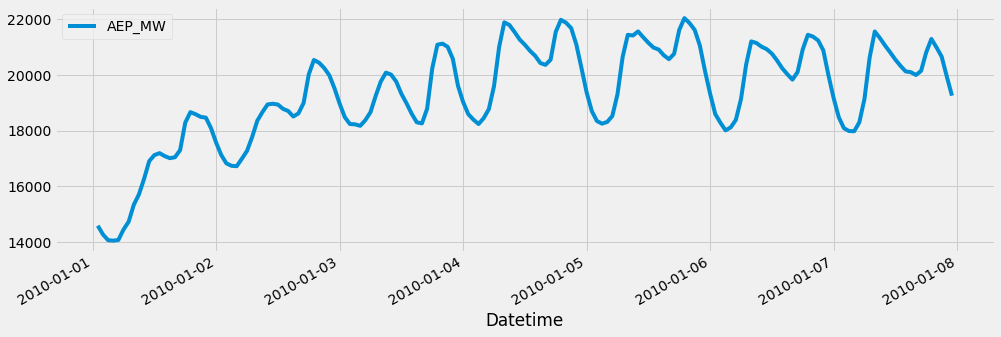

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5))
plt.show()

## Time series cross validation

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() # time series split will not work if the index isn't sorted

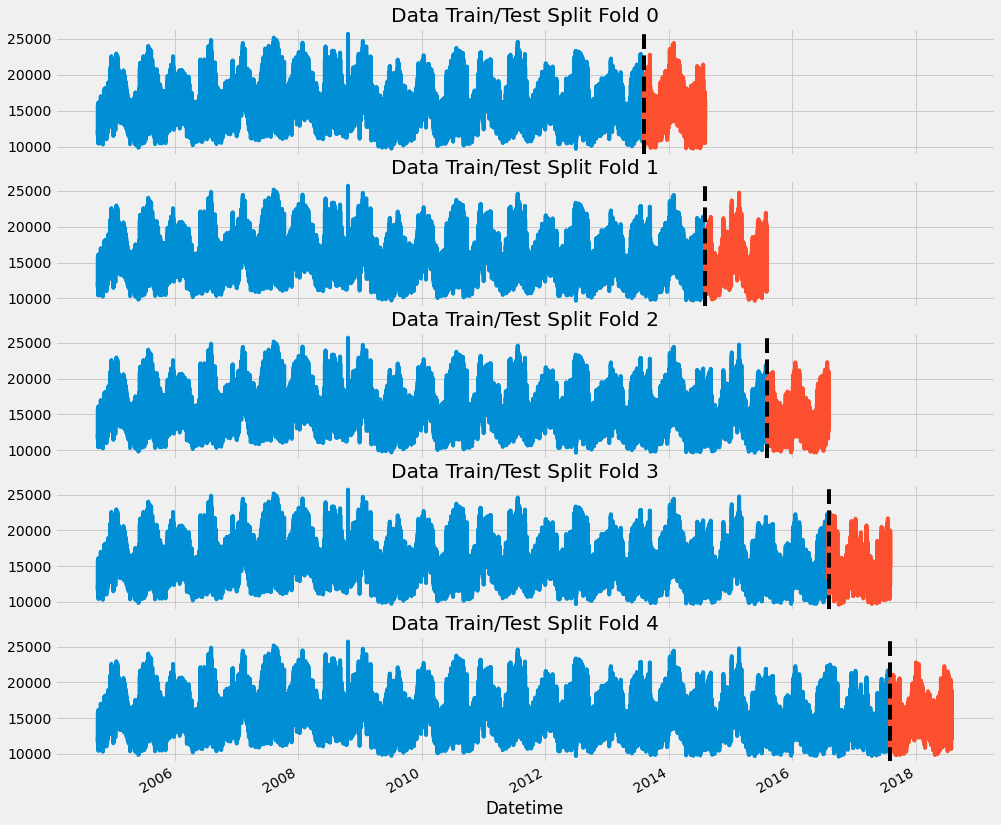

In [9]:
fig, axs = plt.subplots(5, 1, figsize = (15,15), sharex=True)

fold = 0

for train_ix, val_idx in tss.split(df): 
    train = df.iloc[train_ix]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax = axs[fold],
                            label = 'Training Set', 
                            title = f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax = axs[fold], label = 'Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

This test will predict each year independently hence the 'cross validation'. This is an appropiate approach when you have a large timeseries dataset. 

## Forecasting Horizon

The forecast horizon is the legnth of time into the future for which forecasts are to be prepared. These generally vary from short-term (less than three months) to long-term (more than two years). 

## Feature Creation

In [10]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag features
- What was the target(x) days in the past

In [11]:
target_map = df['AEP_MW'].to_dict()

In [12]:
def add_lags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # this same day last year on the same day of the year
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) 
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) 
    return df

df= add_lags(df)

## Visualize our Feature / Target Relationship

Text(0.5, 1.0, 'MW by hour')

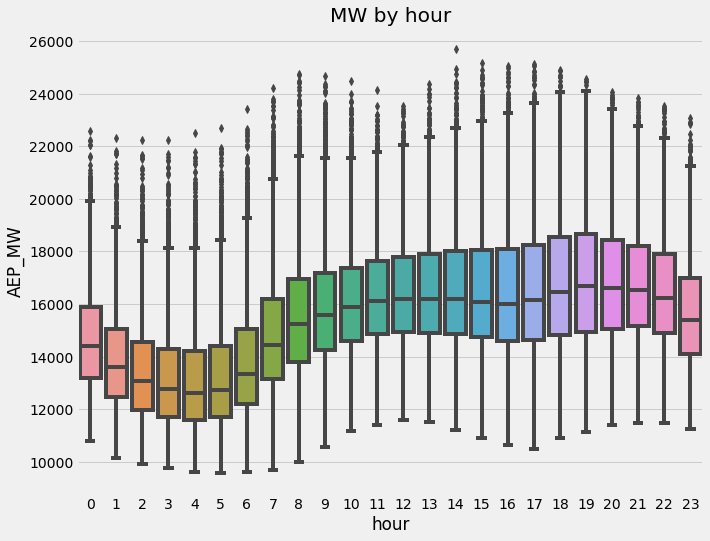

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'hour', y = "AEP_MW")
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by month')

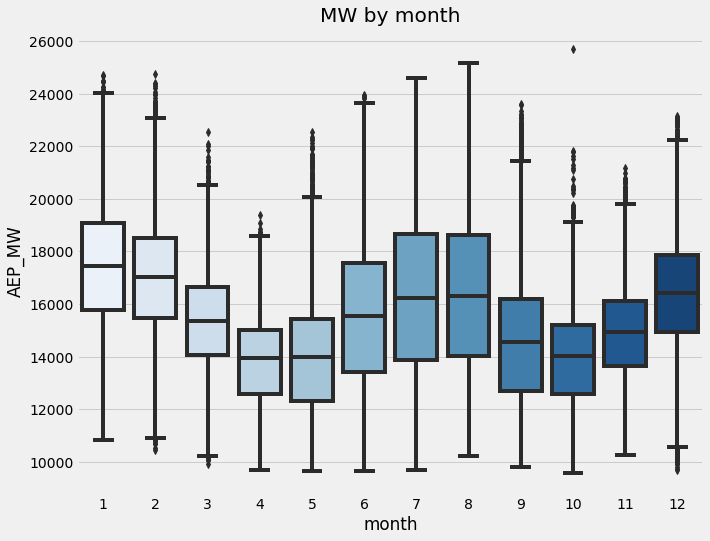

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'month', y = "AEP_MW", palette="Blues")
ax.set_title('MW by month')

## Create our Model

In [15]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:31:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15898.36248	validation_1-rmse:15264.17093
[100]	validation_0-rmse:6031.01245	validation_1-rmse:5645.57605
[200]	validation_0-rmse:2654.67736	validation_1-rmse:2430.85872
[300]	validation_0-rmse:1711.09082	validation_1-rmse:1642.21380
[400]	validation_0-rmse:1491.06784	validation_1-rmse:1550.80241
[458]	validation_0-rmse:1448.83882	validation_1-rmse:1554.64370
[09:31:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15835.43826	validation_1-rmse:15221.94439
[100]	validation_0-rmse:6007.65137	validation_1-rmse:5714.44882
[200]	validation_0-rmse:2645.38093	validation_1-rmse:2505.70100
[300]	validation_0-rmse:1707.68248	validation_1-rmse:161

In [16]:
print(f'Score acrose folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score acrose folds 1563.8093
Fold scores:[1550.7101033290871, 1424.0135873965073, 1494.1182288251418, 1653.0863855420507, 1697.1184316271147]


These are the scores we would look to improve upon by adding more features to the model. 

## Feature Importance

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_, 
            index = reg.feature_names_in_, 
            columns = ['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

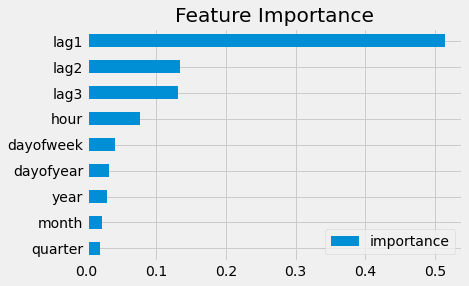

In [18]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

From the above bar chart we can see that the model has been using the hour feature the greatest. This gives us a good idea of what our model is using.

## Forecast on Test

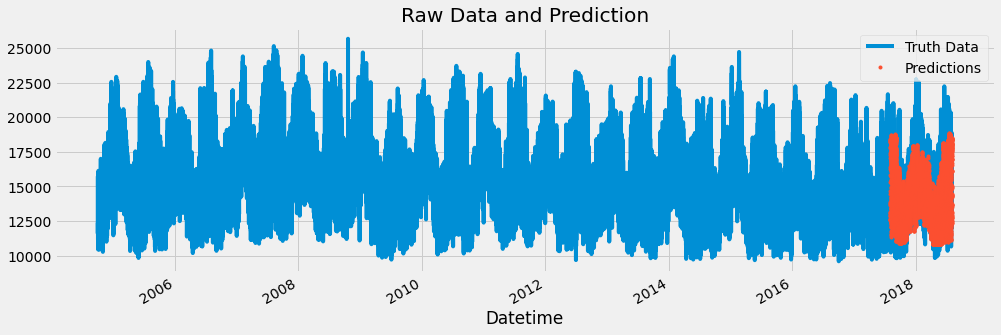

In [19]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how = 'left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax =ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

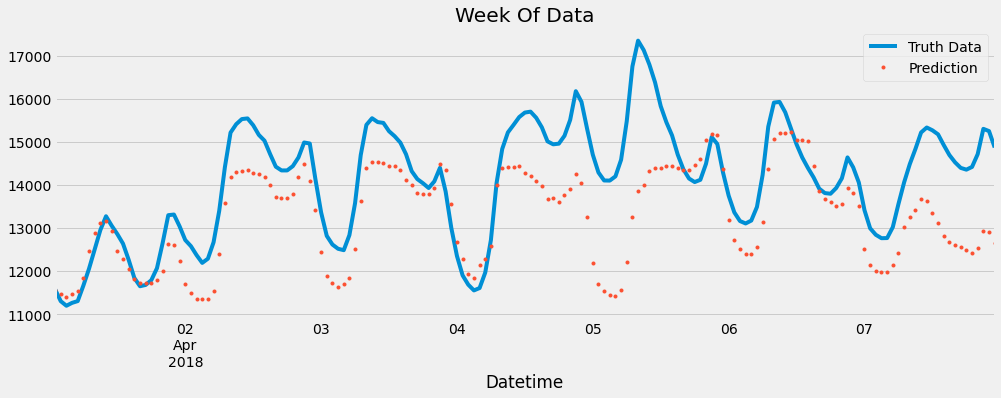

In [20]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'].plot(figsize=(15, 5), title = 'Week Of Data') #orginal data

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style = '.') #predicted data

plt.legend(['Truth Data', 'Prediction'])
plt.show()

In a future model we may be able to make its predictions more aggressive. Many imporvements to be made:
- Better parameter tuning. 
- Add in features for holidays. 

In [21]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1697.12


## Calculate Error
- Lets look at the best and worst predicted days

In [22]:
test

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,13682.0,1,3,3,8,2017,215,3,31,15045.0,13766.0,13230.0,13746.196289
2017-08-03 02:00:00,12841.0,2,3,3,8,2017,215,3,31,14258.0,13034.0,12648.0,13127.006836
2017-08-03 03:00:00,12443.0,3,3,3,8,2017,215,3,31,13758.0,12631.0,12124.0,12835.122070
2017-08-03 04:00:00,12213.0,4,3,3,8,2017,215,3,31,13330.0,12467.0,11929.0,12594.237305
2017-08-03 05:00:00,12286.0,5,3,3,8,2017,215,3,31,13257.0,12474.0,11851.0,12536.909180
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18705.0,20140.0,16078.0,17490.875000
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18108.0,19616.0,15908.0,17375.609375
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17544.0,19246.0,15783.0,17234.093750


In [23]:
test['error'] = np.abs(test['AEP_MW'] - test['prediction'])

In [24]:
test['date'] = test.index.date

In [25]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2018-01-02    5802.084025
2017-12-31    5075.040080
2018-01-01    4947.895060
2018-01-17    4916.345378
2018-01-03    4818.562337
Name: error, dtype: float64

The worst predictions were made in late December, early January. Understanding the dates with the highest RMSE, we can focus to improve our model in these areas. 

In [26]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2018-04-23    132.890706
2018-06-22    168.519287
2018-02-11    197.874552
2017-12-22    206.511637
2018-06-05    216.457886
Name: error, dtype: float64

## Predicting the Future
- Retrain on all data
- To predict the future we need an empty dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [27]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,    # around 500 iters is when the model began to overfit
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[09:32:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15558.94046
[100]	validation_0-rmse:5908.70698
[200]	validation_0-rmse:2621.87051
[300]	validation_0-rmse:1721.51661
[400]	validation_0-rmse:1522.99938
[499]	validation_0-rmse:1471.99676


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [28]:
# Create future dataframe
future =pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [29]:
future_w_features = df_and_future.query('isFuture').copy()

In [30]:
future_w_features

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,15045.0,16491.0,13669.0,NaN,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,13940.0,15319.0,12772.0,NaN,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,13230.0,14492.0,12253.0,NaN,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,12624.0,13945.0,11928.0,NaN,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,12410.0,13619.0,11696.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,16579.0,18495.0,20026.0,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,16457.0,17771.0,19529.0,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,16197.0,17220.0,19029.0,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,15259.0,16100.0,17790.0,NaN,True


## Predict the future

In [31]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<AxesSubplot:title={'center':'Future Predictions'}>

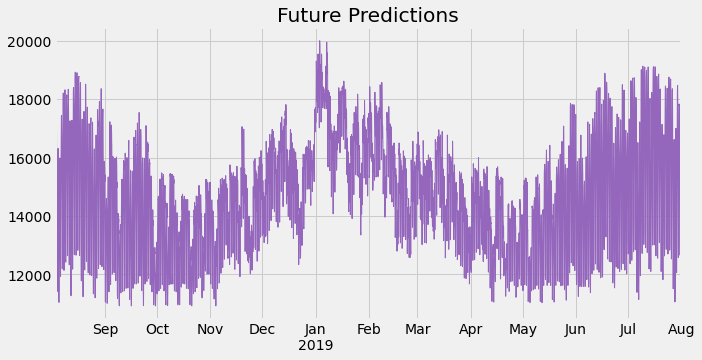

In [32]:
future_w_features['pred'].plot(figsize = (10, 5), 
                                color = color_pal[4], 
                                ms = 1, 
                                lw = 1, 
                                title = 'Future Predictions')